In [1]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path
import re
from ast import literal_eval
import json
import string
import os
from datetime import datetime


# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

from IPython.display import display, Latex, Markdown

# Setup

In [2]:
sent = pd.read_csv(filepath_or_buffer='vader_lexicon.txt',
                  sep='\t',
                  usecols=[0,1],
                  header = None,
                  names=['token','polarity'],
                  index_col='token')

In [3]:
df = pd.read_csv('/Users/anoglows/Documents/movieProject/disney_scripts/csv/budget_table.txt')
df = df.drop(columns=('Ref(s)'))

In [4]:
# HELPER FUNCTION THAT CREATES DICTIONARY
def create_dictionary():
    file_path = '/Users/anoglows/Documents/movieProject/disney_scripts/incomplete/'
    scripts = dict()

    files = os.listdir(file_path)
    for name in files:
        if len(re.findall(r'.txt', name)) > 0:
            movie_name = name[0:len(name)-4]
            scripts[movie_name] = file_path + name
    return scripts

In [5]:
scripts = create_dictionary()

In [6]:
#for key in scripts:
def clean_script(movie):
    script = open(scripts[movie], 'r').read()
    script = re.sub(r'\n', " ", script)
    script = re.sub(r'\'', "", script)
    script = re.sub(r'-', "", script)
    script = script.lower()

    punct_re = r'[^\s\w]'
    script = re.sub(punct_re, " ", script)

    space_re = r' +'
    script = re.sub(space_re, " ", script)
    word_count = len(script.split(' '))
    char_count = len(re.findall(r'[a-z]', script))

    return script, word_count, char_count
    

In [7]:
df_scripts = pd.DataFrame(columns=[0, 1, 2, 3])
for key in scripts:
    temp = clean_script(key)
    entry = pd.Series([key, temp[0], temp[1], temp[2]])
    df_scripts = df_scripts.append(entry, ignore_index=True)
df_scripts = df_scripts.rename(index= str, columns= {0:'Film', 1:'Script', 2:'Word Count', 3:'Character Count'})


In [8]:
def get_tidy_format(df):
    temp = (df['Script']
        .str.split(expand=True)
        .stack()
        .reset_index(level=1)
        .rename(columns={0:'word','level_1':'num'})
    )
    return temp

In [9]:
def get_polarity(source_df, dest_df):
    dest_df['polarity'] = (
        source_df.merge(sent, how='left', left_on='word', right_index=True)
        .reset_index().loc[:, ['index', 'polarity']].dropna()
        .groupby('index').mean()
    )
    dest_df['pos / neg ratio'] = (
        source_df.merge(sent, how='left', left_on='word', right_index=True)
        .reset_index().loc[:, ['index', 'polarity']]
        .groupby('index').agg([('positive-negative ration' , lambda x : x[x > 0].count()/ x[x < 0].count())])
    )
    return dest_df

In [10]:
def script_to_polarity(df):
    tidy_df = get_tidy_format(df)
    polar_df = get_polarity(tidy_df, df)
    return polar_df

In [11]:
df_scripts = script_to_polarity(df_scripts)

In [12]:
df = df.merge(df_scripts)

In [13]:
df_release_dates = pd.read_csv('/Users/anoglows/Documents/movieProject/disney_scripts/csv/release_dates.txt')

In [14]:
df = df.merge(df_release_dates)

In [15]:
df['Original release date'] = pd.to_datetime(df['Original release date'])
money_reg = r' million|\,|\$'
df['Budget'] = df['Budget'].str.replace(money_reg, '').astype(float)
df['Opening'] = df['Opening'].str.replace(money_reg, '').astype(float)
df['Domestic'] = df['Domestic'].str.replace(money_reg, '').astype(float)
df['Worldwide'] = df['Worldwide'].str.replace(money_reg, '').astype(float)
df.loc[df['Film'] == 'Dumbo', 'Budget'] = .95
df ['RT'] = df['RT'].str.replace(r'%','').astype(int)/100
df['MC'] = df['MC'].str[0:2].astype(float)/100
df['Opening percent'] = df['Opening'] / df['Domestic']


# Budget to Worldwide Gross

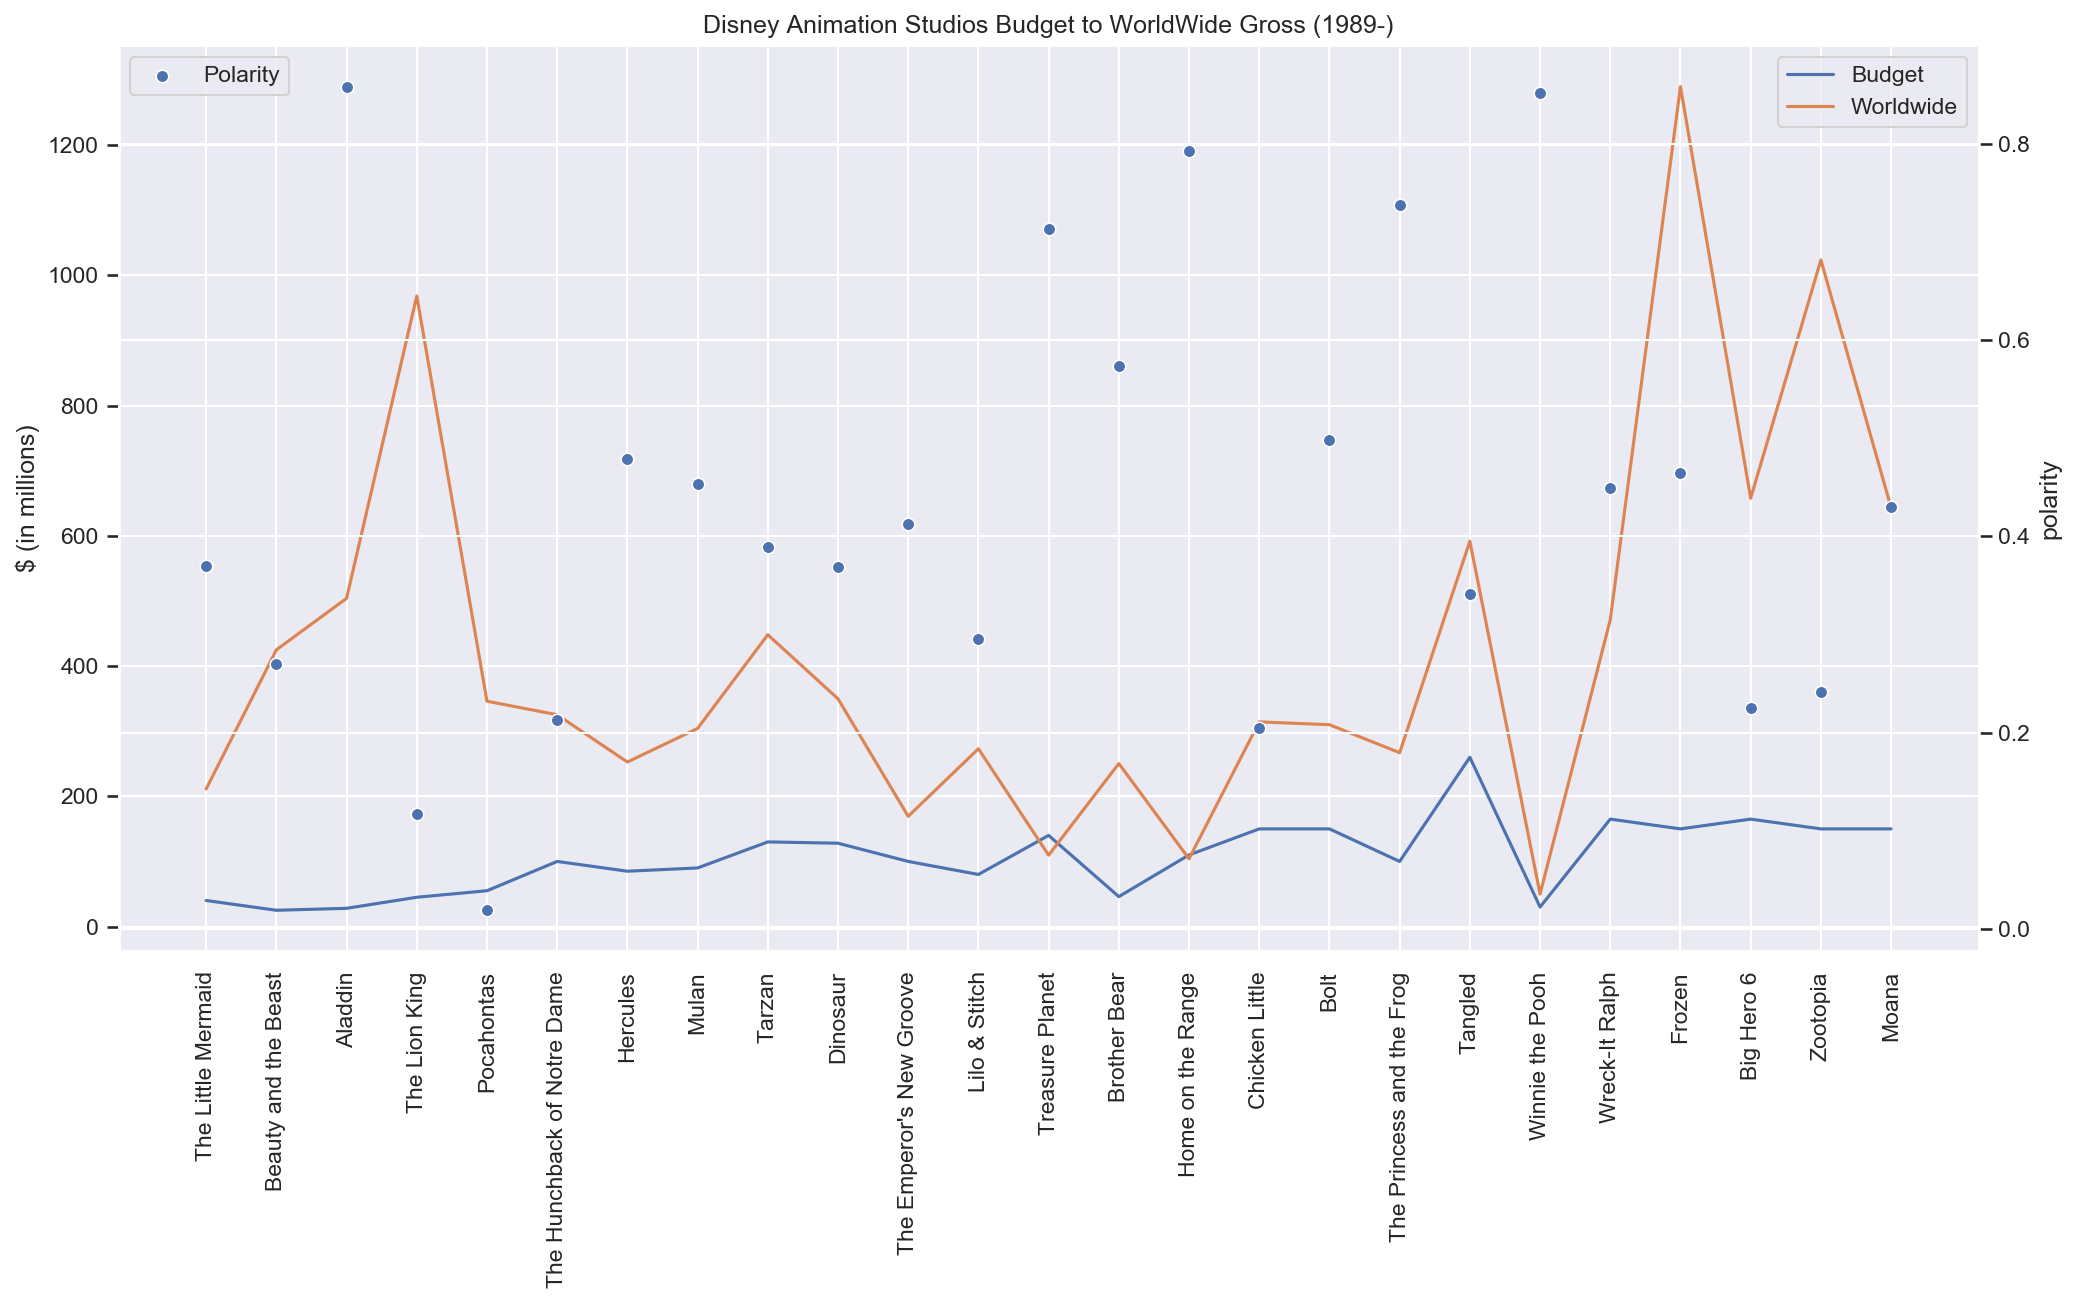

In [16]:
#ax = sns.lineplot(df.index, df['Budget'], label = 'Budget')
#ax = sns.lineplot(df.index, df['Worldwide'], label = 'Worldwide')
#ax = sns.scatterplot(df.index, df.polarity)
#ax.set_title("Disney Animation Studios Budget to WorldWide Gross");
#ax.set_xticklabels(df['Film']);
#ax.set_xticks(df.index);
#[tick.set_rotation(90) for tick in ax.get_xticklabels()];



df_temp = df.iloc[21:,:]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = sns.lineplot(df_temp.index, df_temp['Budget'], label = 'Budget')
ax1 = sns.lineplot(df_temp.index, df_temp['Worldwide'], label = 'Worldwide')
ax1.set_ylabel('$ (in millions)')

ax2 = ax1.twinx()
ax2 = sns.scatterplot(df_temp.index, df_temp.polarity, label = 'Polarity')
ax2.set_ylabel('polarity')
ax2.legend(loc=2)

ax1.set_title("Disney Animation Studios Budget to WorldWide Gross (1989-)");
ax1.set_xticklabels(df_temp['Film']);
ax1.set_xticks(df_temp.index);
[tick.set_rotation(90) for tick in ax1.get_xticklabels()];

# Gross To Ratings

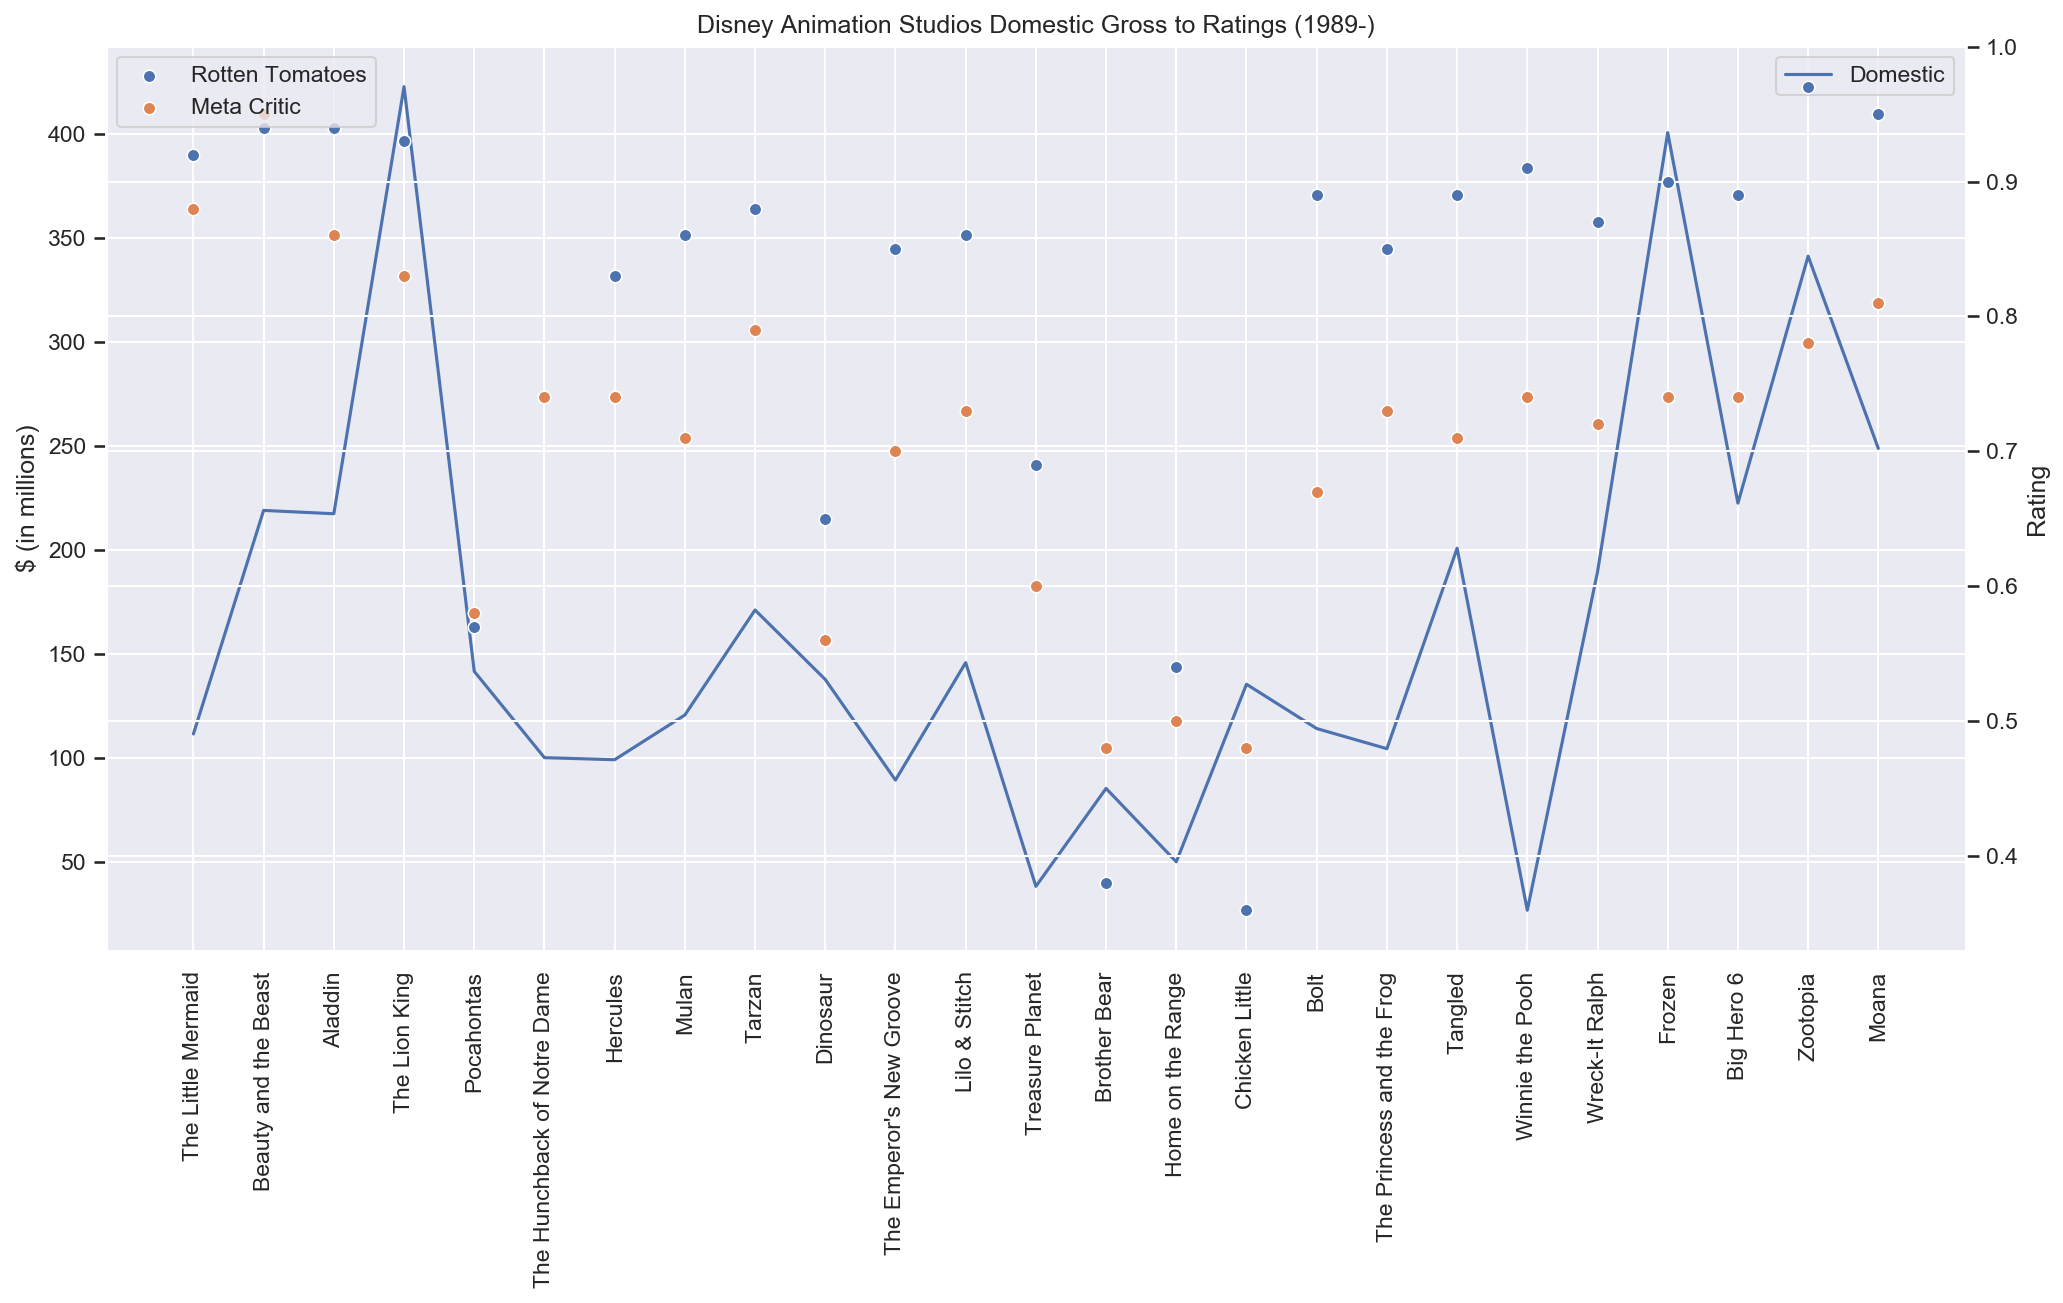

In [17]:
df_temp = df.iloc[21:,:]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = sns.lineplot(df_temp.index, df_temp['Domestic'], label = 'Domestic')
ax1.set_ylabel('$ (in millions)')

ax2 = ax1.twinx()
ax2 = sns.scatterplot(df_temp.index, df_temp['RT'], label = 'Rotten Tomatoes')
ax2 = sns.scatterplot(df_temp.index, df_temp['MC'], label = 'Meta Critic')

ax2.set_ylabel('Rating')
ax2.legend(loc=2)

ax1.set_title("Disney Animation Studios Domestic Gross to Ratings (1989-)");
ax1.set_xticklabels(df_temp['Film']);
ax1.set_xticks(df_temp.index);
[tick.set_rotation(90) for tick in ax1.get_xticklabels()];

# Budget Over Time

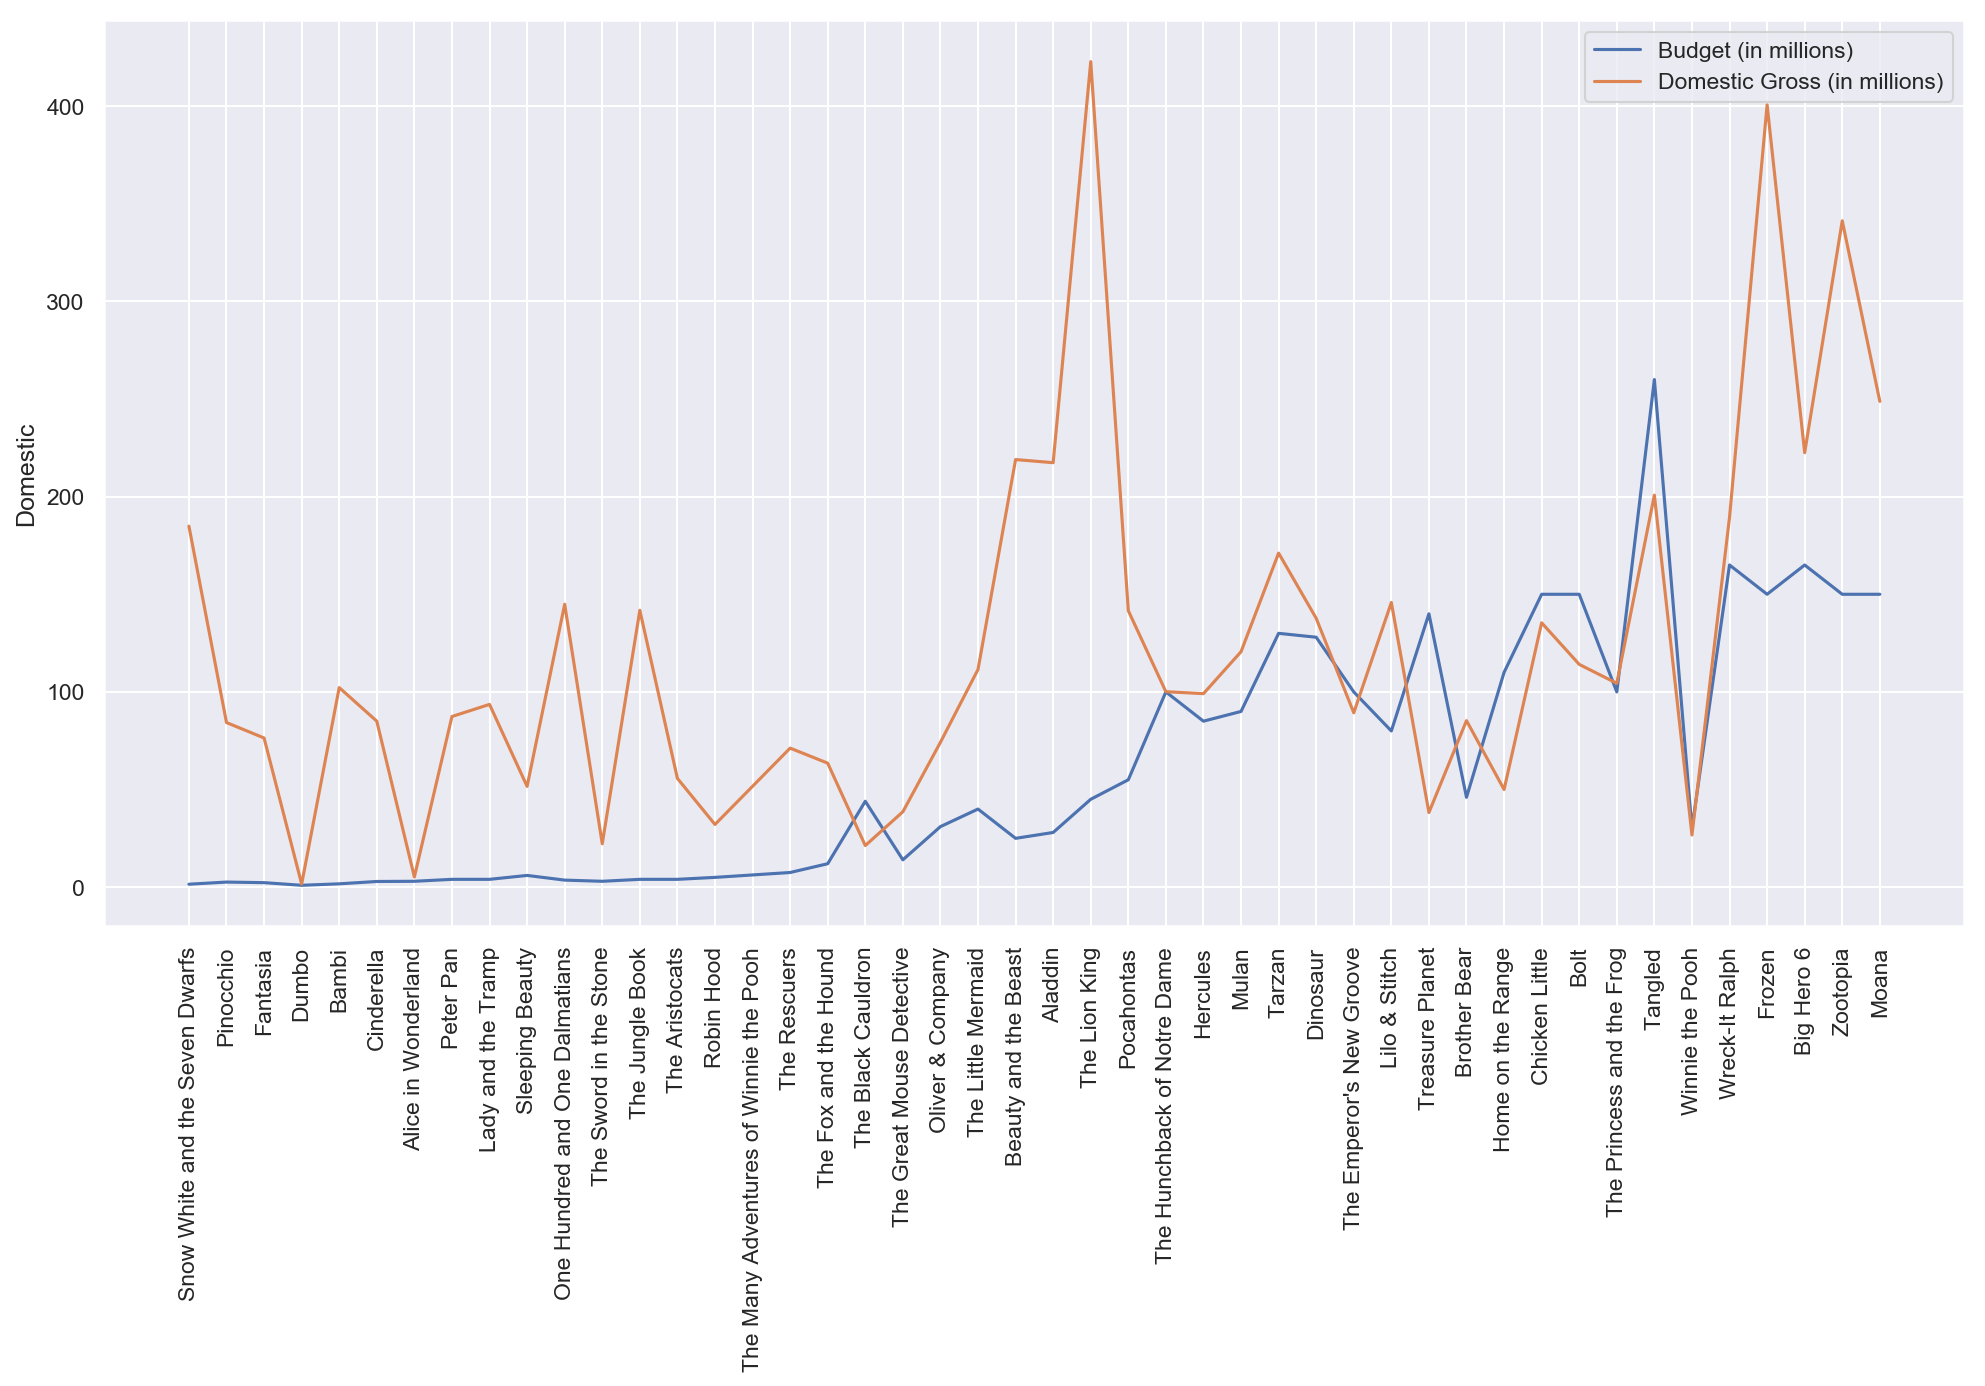

In [18]:
ax1 = sns.lineplot(df.index, df['Budget'], label = 'Budget (in millions)')
ax1 = sns.lineplot(df.index, df['Domestic'], label = 'Domestic Gross (in millions)')

ax1.set_xticklabels(df['Film']);
ax1.set_xticks(df.index);
[tick.set_rotation(90) for tick in ax1.get_xticklabels()];

In [19]:
df.sort_values('MC')[['Film', 'MC', 'RT', 'Original release date']].head()

,Film,MC,RT,Original release date
34,Brother Bear,0.48,0.38,2003-11-01
36,Chicken Little,0.48,0.36,2005-11-04
35,Home on the Range,0.50,0.54,2004-04-02
30,Dinosaur,0.56,0.65,2000-05-19
14,Robin Hood,0.57,0.52,1973-11-08


In [20]:
df.sort_values('MC', ascending=False)[['Film', 'MC', 'RT', 'Original release date']].head()

,Film,MC,RT,Original release date
1,Pinocchio,0.99,1.00,1940-02-07
3,Dumbo,0.98,0.97,1941-10-23
2,Fantasia,0.96,0.96,1940-11-13
0,Snow White and the Seven Dwarfs,0.95,0.98,1937-12-21
22,Beauty and the Beast,0.95,0.94,1991-11-22


In [21]:
df.sort_values('RT')[['Film', 'MC', 'RT', 'Original release date']].head()

,Film,MC,RT,Original release date
36,Chicken Little,0.48,0.36,2005-11-04
34,Brother Bear,0.48,0.38,2003-11-01
20,Oliver & Company,0.58,0.44,1988-11-18
14,Robin Hood,0.57,0.52,1973-11-08
35,Home on the Range,0.50,0.54,2004-04-02


In [22]:
df.sort_values('RT', ascending=False)[['Film', 'MC', 'RT', 'Original release date']].head()

,Film,MC,RT,Original release date
1,Pinocchio,0.99,1.00,1940-02-07
15,The Many Adventures of Winnie the Pooh,NaN,1.00,1977-03-11
0,Snow White and the Seven Dwarfs,0.95,0.98,1937-12-21
10,One Hundred and One Dalmatians,0.83,0.98,1961-01-25
3,Dumbo,0.98,0.97,1941-10-23


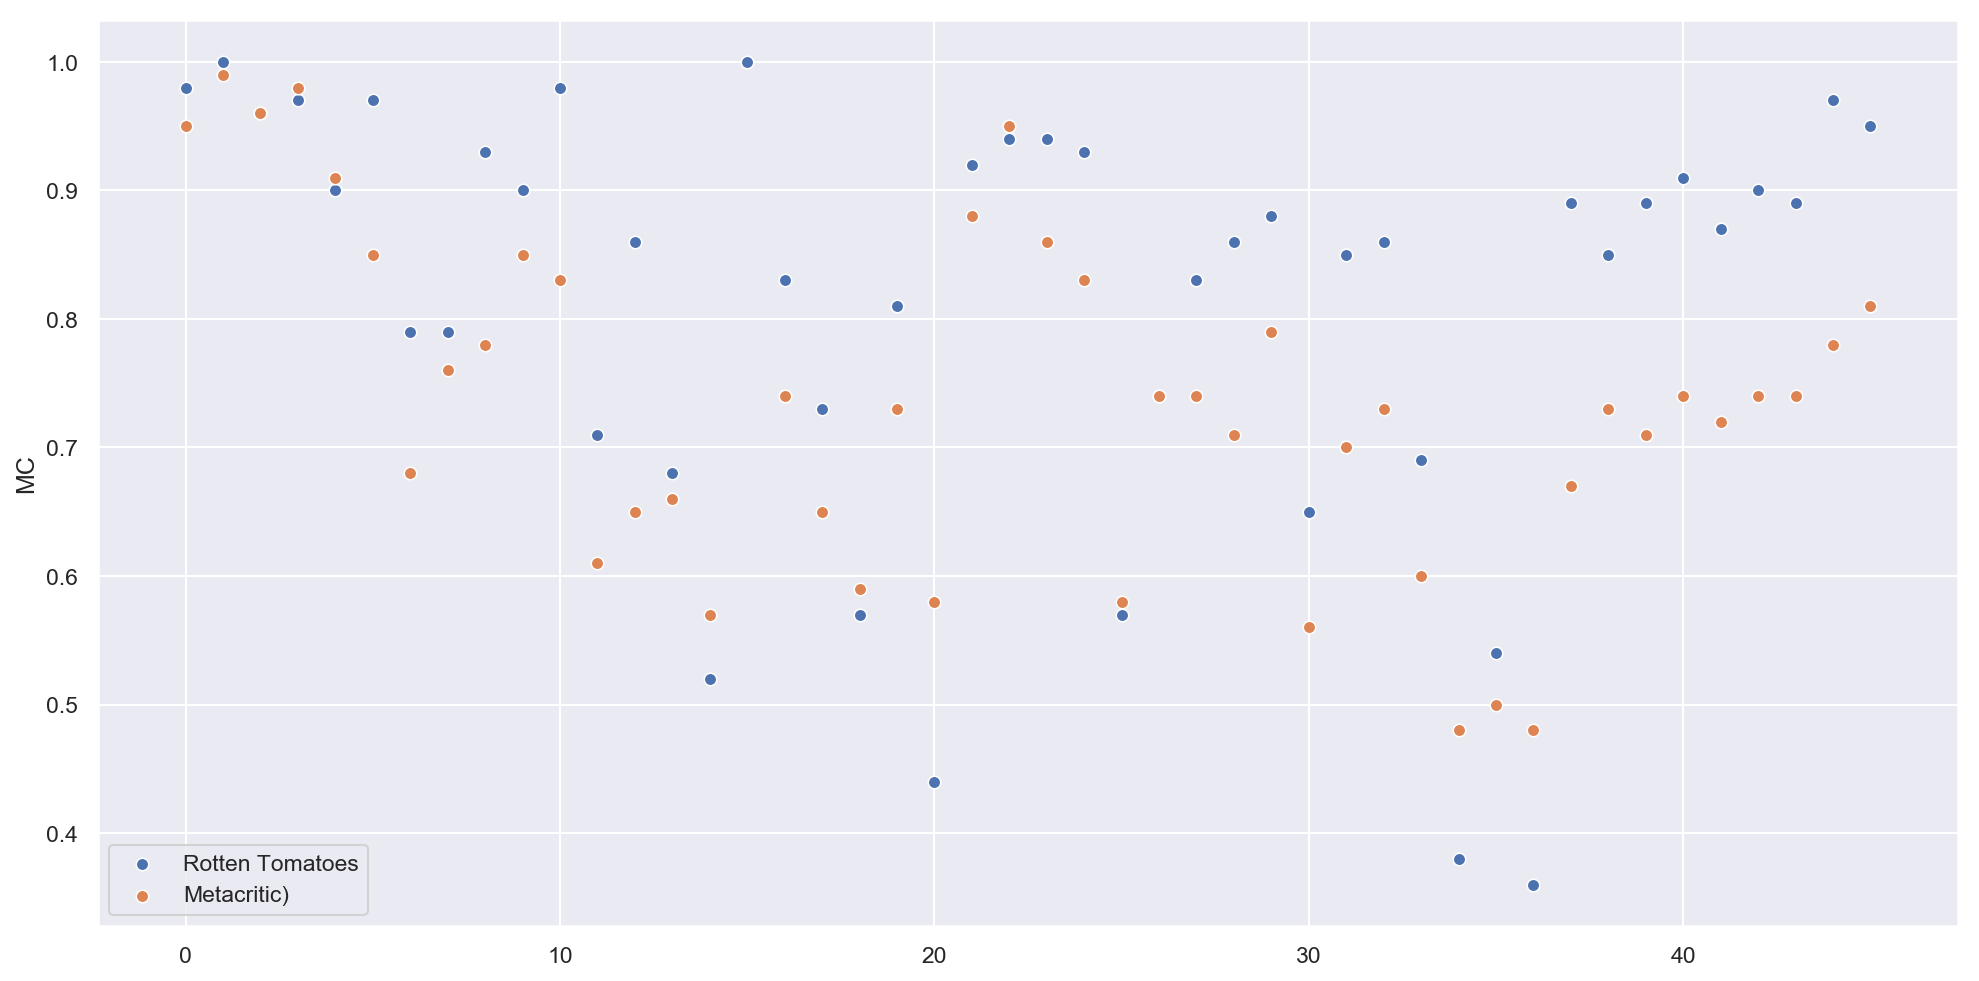

In [23]:
ax1 = sns.scatterplot(df.index, df['RT'], label = 'Rotten Tomatoes')
ax1 = sns.scatterplot(df.index, df['MC'], label = 'Metacritic)')


In [24]:
np.mean(df['RT'])

0.8126086956521739

In [25]:
np.mean(df['MC'])

0.7353333333333331

In [26]:
df

,Film,Budget,Opening,Domestic,Worldwide,RT,MC,Script,Word Count,Character Count,polarity,pos / neg ratio,Original release date,Opening percent
0,Snow White and the Seven Dwarfs,1.50,NaN,184.9,416.0,0.98,0.95,slave in the magic mirror come from the farthe...,3996,15414,0.433262,1.695402,1937-12-21,NaN
1,Pinocchio,2.60,NaN,84.3,NaN,1.00,0.99,when you wish upon a star makes no difference ...,6146,23977,0.652683,2.186528,1940-02-07,NaN
2,Fantasia,2.30,NaN,76.4,NaN,0.96,0.96,how do you do my name is deems taylor and its ...,1784,7992,0.828319,2.424242,1940-11-13,NaN
3,Dumbo,0.95,NaN,1.6,NaN,0.97,0.98,through the snow and sleet and hail through th...,4167,16348,0.761153,2.500000,1941-10-23,NaN
4,Bambi,1.70,NaN,102.2,267.4,0.90,0.91,love is a song that never ends life may be swi...,1926,7825,1.195946,3.440000,1942-08-13,NaN
5,Cinderella,2.90,NaN,85.0,263.6,0.97,0.85,cinderella youre as ioveiy as your name cinder...,5374,22204,0.638605,2.213115,1950-02-15,NaN
6,Alice in Wonderland,3.00,NaN,5.2,NaN,0.79,0.68,alice in wonderland how do you get to wonderla...,6990,27074,0.611940,1.983806,1951-07-28,NaN
7,Peter Pan,4.00,NaN,87.4,145.0,0.79,0.76,the second star to the right shines in the nig...,7013,27398,0.462358,1.607407,1953-02-05,NaN
8,Lady and the Tramp,4.00,NaN,93.6,NaN,0.93,0.78,this is the night its a beautiful night and th...,5053,20155,0.797917,2.267016,1955-06-22,NaN
9,Sleeping Beauty,6.00,NaN,51.6,NaN,0.90,0.85,sleeping beauty\ti know you i walked with you ...,4452,17939,0.858989,2.708333,1959-01-29,NaN


In [27]:
display(np.mean(df.iloc[0:11,:]['RT']))
display(np.mean(df.iloc[11:21,:]['RT']))
display(np.mean(df.iloc[21:29,:]['RT']))
display(np.mean(df.iloc[29:38,:]['RT']))
display(np.mean(df.iloc[38:,:]['RT']))

0.9245454545454547

0.7150000000000001

0.84125

0.6777777777777777

0.9037499999999999

In [28]:
display(np.mean(df.iloc[0:11,:]['polarity']))
display(np.mean(df.iloc[11:21,:]['polarity']))
display(np.mean(df.iloc[21:29,:]['polarity']))
display(np.mean(df.iloc[29:38,:]['polarity']))
display(np.mean(df.iloc[38:,:]['polarity']))

0.6909110256948167

0.4660677149776037

0.3471864145255629

0.47191718166358626

0.46743550885862595

In [29]:
display(np.mean(df['polarity']))

0.5005419229231479

In [30]:
df.sort_values('polarity', ascending=False)[['Film', 'polarity', 'Original release date']].head(10)

,Film,polarity,Original release date
4,Bambi,1.195946,1942-08-13
15,The Many Adventures of Winnie the Pooh,0.887686,1977-03-11
9,Sleeping Beauty,0.858989,1959-01-29
23,Aladdin,0.857579,1992-11-25
40,Winnie the Pooh,0.851814,2011-07-15
2,Fantasia,0.828319,1940-11-13
13,The Aristocats,0.807282,1970-12-24
8,Lady and the Tramp,0.797917,1955-06-22
35,Home on the Range,0.792685,2004-04-02
3,Dumbo,0.761153,1941-10-23


In [31]:
df.sort_values('polarity', ascending=True)[['Film', 'polarity', 'Original release date']].head(10)

,Film,polarity,Original release date
20,Oliver & Company,0.003364,1988-11-18
25,Pocahontas,0.019275,1995-06-23
24,The Lion King,0.117047,1994-06-24
36,Chicken Little,0.204394,2005-11-04
26,The Hunchback of Notre Dame,0.212308,1996-06-21
43,Big Hero 6,0.224966,2014-11-07
44,Zootopia,0.240991,2016-03-04
22,Beauty and the Beast,0.270209,1991-11-22
32,Lilo & Stitch,0.295325,2002-06-21
39,Tangled,0.340839,2010-11-24


## IN DEPTH LINE ANALYSIS

In [32]:
# HELPER FUNCTION THAT CREATES DICTIONARY
def create_dictionary():
    file_path = '/Users/anoglows/Documents/movieProject/disney_scripts/'
    scripts = dict()

    files = os.listdir(file_path)
    for name in files:
        if len(re.findall(r'.txt', name)) > 0:
            movie_name = name[0:len(name)-4]
            scripts[movie_name] = file_path + name
    return scripts

In [33]:
# HELPER FUNCTION TO REMOVE PUNCTION AND MAKE LOWER CASE
def get_clean_quote(quote):
    punct_re = r'[^\s\w]'
    clean_quote = quote.lower()
    clean_quote = re.sub(punct_re, " ", clean_quote)
    return clean_quote

In [111]:
# HELPER FUNCTIOON TO REMOVE STAGE DIRECTIONS
def get_no_stage_quote(quote):
    punct_re1 = r'\(.+\)'
    punct_re2 = r'\[.+\]'
    punct_re3 = r'\{.+\}'
    clean_quote = quote.lower()
    clean_quote = re.sub(punct_re1, ' ', clean_quote)
    clean_quote = re.sub(punct_re2, ' ', clean_quote)
    clean_quote = re.sub(punct_re3, ' ', clean_quote)

    return clean_quote

In [112]:
# HELPER FUNCTION TO GETE EACH LINE
def find_lines(script_txt, movie_title):
    df = pd.DataFrame(columns=[0, 1, 2, 3, 4, 5])
    script = open(script_txt,'r')
    lines = script.read().split('\n')
    index = 0
    for line in lines:  
        if len(re.findall(r"^[^:]+:", line)) > 0:
            begin_index = len(re.findall(r"^[^:]+:", line)[0])+1
            character = re.findall(r"^[^:]+:", line)[0][0:begin_index - 2]
            quote = line[begin_index:len(line)]
            clean_quote = get_clean_quote(quote)
            no_stage_quote = get_clean_quote(get_no_stage_quote(quote))
            entry = pd.Series([movie_title, index, character, quote, clean_quote, no_stage_quote])
            df = df.append(entry, ignore_index=True)
            index += 1
    df = df.rename(index= str, columns= {0:'movie_title', 1:'index', 2:'character', 3:'quote', 4:'clean_quote', 5:'no_stage_quote'})
    return df

In [113]:
# HELPER FUNCTION FOR SCRIPT_TO_POLARITY TO TRANSFORM DATAFRAME TO GET POLARITY
def get_tidy_format(df, col):
    temp = (df[col]
        .str.split(expand=True)
        .stack()
        .reset_index(level=1)
        .rename(columns={0:'word','level_1':'num'})
    )
    return temp

In [114]:
# HELPER FUNCTION TO GET POLARITY OF A SCRIPT
def get_polarity(source_df, dest_df):
    dest_df['polarity'] = (
        source_df.merge(sent, how='left', left_on='word', right_index=True)
        .reset_index().loc[:, ['index', 'polarity']]
        .groupby('index').sum().fillna(0)
    )
    return dest_df

In [115]:
# FUNCTION TO TRANSFORM A SCRIPT INTO DATAFRAME
def script_to_polarity(script_txt, movie_title, col='no_stage_quote'):
    
    df = find_lines(script_txt, movie_title)
    tidy_df = get_tidy_format(df, col)
    polar_df = get_polarity(tidy_df, df)
    nonzero_polar_df = polar_df[polar_df['polarity'] != 0.0]
    return polar_df, nonzero_polar_df

In [116]:
# FUNCTION TO GET MOST NEGATIVE QUOTES FROM A MOVIE
def get_most_negative_quotes(df, min_lines=0, num=5):
    df = df.groupby('character').filter(lambda x: x['polarity'].count() >= min_lines)
    return df.sort_values('polarity').head(num)

In [117]:
# FUNCTION TO GET MOST POSITIVE QUOTES FROM A MOVIE
def get_most_positive_quotes(df, min_lines=0, num=5):
    df = df.groupby('character').filter(lambda x: x['polarity'].count() >= min_lines)
    return df.sort_values('polarity', ascending=False).head(num)

In [118]:
# FUNCTION TO GET A CHARACTERS LINES
def get_character_lines(df, character, sortby='index'):
    return df[df['character'].str.lower() == character.lower()].sort_values(sortby)

In [119]:
# FUNCTION THTAGETS AVERAGE POLARITY FOR CHARACTERS IN A MOVIE
def get_character_avg_polarity_list(df, num_characters=5):
    return df.groupby(['movie_title', 'character']).agg({'index':'count','polarity':'mean'}).sort_values('index', ascending=False).head(num_characters).sort_values('polarity').rename(index=str, columns={'index':'line_count'}) 

In [120]:
# FUNCTION THAT GETS THE AVERAGE POLARITY OF EACH LINE IN A MOVIE
def get_movie_line_avg_polarity(df, col):
    df = df.dropna()
    return df.groupby('movie_title')['polarity'].mean(), df['polarity'].sum() / len(df[df['polarity'] != 0.0])

In [121]:
scripts = create_dictionary()

In [122]:
dfs = dict()
nonzero_dfs = dict()
for key in scripts:
    dfs[key], nonzero_dfs[key] = script_to_polarity(scripts[key] , key)

In [123]:
dfs.keys()

dict_keys(['Aladdin', 'Frozen', 'Moana', 'Mulan', 'Pinocchio', 'The Lion King', 'Zootopia'])

## LION KING

In [124]:
# FUNCTION THAT RETURNS CHARACTERS FROM MOVIE WITH MOST LINES
def get_characters_with_most_lines(movie, num = 5):
    return dfs[movie].groupby('character').count().sort_values('index',ascending=False).index[0:num]

In [125]:
import collections, re, operator
for key in dfs:
    bagsofwords = [collections.Counter(re.findall(r'\w+', line)) for line in dfs[key]['no_stage_quote']]
    dfs[key]['bags'] = bagsofwords

In [126]:
list(dfs.keys())
word_counts = {}
for movie in dfs:
    t = pd.DataFrame()
    for character in get_characters_with_most_lines(movie, 5):
        temp = pd.Series(sum(dfs[movie][dfs[movie]['character'] == character]['bags'], collections.Counter()).most_common())
        t[character] = temp
    word_counts[movie] = t

In [127]:
for key in word_counts:
    display(word_counts[key].head(10))

,ALADDIN,JASMINE,JAFAR,GENIE,SULTAN
0,"(i, 67)","(i, 30)","(you, 30)","(you, 17)","(you, 14)"
1,"(you, 54)","(you, 30)","(the, 30)","(a, 16)","(jasmine, 12)"
2,"(the, 31)","(a, 16)","(i, 24)","(s, 15)","(i, 11)"
3,"(a, 29)","(the, 15)","(to, 24)","(i, 14)","(jafar, 11)"
4,"(to, 28)","(oh, 12)","(me, 13)","(he, 12)","(oh, 10)"
5,"(m, 24)","(to, 12)","(s, 13)","(the, 12)","(to, 9)"
6,"(me, 24)","(what, 12)","(my, 12)","(al, 9)","(a, 9)"
7,"(s, 23)","(s, 12)","(your, 12)","(and, 7)","(the, 8)"
8,"(abu, 22)","(she, 11)","(a, 12)","(are, 7)","(s, 8)"
9,"(he, 21)","(t, 9)","(it, 10)","(me, 7)","(this, 8)"


,Anna,Kristoff,Hans,Elsa,Olaf
0,"(i, 115)","(you, 51)","(you, 35)","(you, 35)","(i, 30)"
1,"(you, 82)","(i, 41)","(i, 31)","(t, 29)","(you, 23)"
2,"(it, 46)","(it, 28)","(to, 19)","(i, 27)","(and, 15)"
3,"(the, 40)","(s, 23)","(the, 17)","(no, 21)","(s, 14)"
4,"(no, 37)","(t, 23)","(anna, 12)","(don, 18)","(to, 14)"
5,"(to, 37)","(to, 18)","(with, 11)","(to, 16)","(the, 13)"
6,"(s, 35)","(a, 17)","(her, 11)","(the, 15)","(a, 10)"
7,"(t, 31)","(what, 15)","(s, 9)","(it, 12)","(it, 9)"
8,"(m, 29)","(no, 15)","(was, 9)","(me, 11)","(t, 9)"
9,"(what, 27)","(don, 15)","(she, 9)","(what, 11)","(like, 9)"


,Moana,Maui,Tui,Gramma,Tamatoa
0,"(i, 116)","(you, 107)","(you, 28)","(the, 58)","(you, 34)"
1,"(the, 109)","(i, 81)","(the, 20)","(you, 37)","(i, 22)"
2,"(you, 90)","(the, 70)","(we, 15)","(to, 24)","(a, 19)"
3,"(it, 53)","(it, 67)","(and, 13)","(and, 22)","(it, 14)"
4,"(no, 40)","(s, 55)","(to, 13)","(i, 17)","(the, 14)"
5,"(we, 40)","(a, 49)","(there, 12)","(of, 14)","(s, 12)"
6,"(to, 38)","(re, 42)","(a, 12)","(a, 12)","(shiny, 11)"
7,"(me, 37)","(to, 34)","(moana, 11)","(te, 11)","(to, 11)"
8,"(s, 36)","(and, 31)","(i, 11)","(heart, 10)","(can, 10)"
9,"(and, 34)","(not, 26)","(no, 10)","(will, 10)","(t, 10)"


,Mulan,Mushu,Shang,Chi Fu,Yao
0,"(i, 64)","(you, 63)","(the, 29)","(the, 21)","(you, 6)"
1,"(to, 23)","(i, 50)","(you, 28)","(a, 10)","(i, 5)"
2,"(you, 22)","(the, 36)","(i, 20)","(you, 9)","(and, 4)"
3,"(the, 21)","(s, 35)","(a, 19)","(your, 8)","(it, 3)"
4,"(t, 16)","(to, 33)","(of, 18)","(i, 8)","(ll, 3)"
5,"(my, 15)","(that, 28)","(we, 11)","(family, 7)","(do, 3)"
6,"(me, 14)","(your, 27)","(to, 10)","(s, 7)","(on, 3)"
7,"(a, 13)","(a, 26)","(for, 9)","(to, 5)","(to, 3)"
8,"(it, 12)","(and, 24)","(t, 8)","(are, 5)","(of, 3)"
9,"(m, 10)","(it, 23)","(your, 8)","(be, 5)","(the, 3)"


,Pinocchio,Jiminy Cricket,Geppetto,Honest John,Blue Fairy
0,"(i, 63)","(you, 53)","(you, 26)","(a, 23)","(you, 18)"
1,"(father, 31)","(i, 51)","(s, 23)","(dee, 18)","(and, 11)"
2,"(m, 23)","(a, 42)","(a, 21)","(and, 17)","(pinocchio, 10)"
3,"(me, 21)","(the, 38)","(pinocchio, 20)","(you, 16)","(be, 8)"
4,"(jiminy, 21)","(it, 37)","(i, 19)","(s, 16)","(to, 7)"
5,"(s, 21)","(s, 33)","(now, 16)","(the, 13)","(your, 6)"
6,"(oh, 20)","(t, 22)","(oh, 16)","(of, 12)","(a, 6)"
7,"(a, 18)","(and, 22)","(it, 13)","(to, 10)","(t, 6)"
8,"(you, 17)","(pinoke, 21)","(he, 13)","(yes, 10)","(of, 5)"
9,"(no, 17)","(here, 21)","(figaro, 13)","(i, 10)","(i, 5)"


,Simba,Scar,Timon,Zazu,Nala
0,"(i, 87)","(you, 53)","(you, 39)","(the, 30)","(you, 26)"
1,"(you, 61)","(i, 45)","(s, 25)","(you, 21)","(s, 19)"
2,"(it, 45)","(the, 26)","(a, 19)","(i, 17)","(simba, 17)"
3,"(t, 30)","(it, 23)","(i, 18)","(to, 14)","(i, 15)"
4,"(to, 30)","(no, 23)","(the, 15)","(a, 13)","(the, 14)"
5,"(s, 29)","(oh, 20)","(it, 14)","(that, 10)","(it, 13)"
6,"(what, 26)","(simba, 20)","(what, 13)","(is, 10)","(what, 12)"
7,"(m, 26)","(a, 19)","(pumbaa, 13)","(and, 10)","(we, 8)"
8,"(no, 24)","(to, 16)","(he, 13)","(are, 10)","(he, 8)"
9,"(the, 23)","(of, 16)","(that, 12)","(oh, 10)","(no, 8)"


,Judy Hopps,Nick Wilde,Chief Bogo,Stu Hopps,Dawn Bellwether
0,"(i, 115)","(you, 70)","(you, 20)","(the, 16)","(you, 20)"
1,"(you, 106)","(i, 65)","(to, 14)","(a, 15)","(i, 16)"
2,"(a, 80)","(a, 44)","(the, 13)","(s, 13)","(it, 14)"
3,"(the, 64)","(the, 37)","(i, 11)","(you, 11)","(the, 13)"
4,"(it, 49)","(it, 37)","(a, 10)","(that, 10)","(to, 12)"
5,"(s, 43)","(s, 35)","(t, 8)","(of, 10)","(a, 11)"
6,"(to, 42)","(no, 31)","(not, 7)","(and, 9)","(is, 10)"
7,"(and, 37)","(to, 30)","(hopps, 7)","(to, 7)","(s, 9)"
8,"(what, 34)","(that, 29)","(now, 6)","(we, 7)","(just, 9)"
9,"(is, 33)","(is, 20)","(we, 5)","(there, 7)","(that, 8)"


In [128]:
for key in dfs:
    display(get_character_avg_polarity_list(nonzero_dfs[key], num_characters=5))

line_count  polarity
movie_title character                      
Aladdin     JASMINE            52  0.633333
            JAFAR              45  0.654545
            ALADDIN           113  0.796460
            GENIE              32  0.965517
            SULTAN             30  0.980000

line_count  polarity
movie_title character                      
Frozen      Hans               43 -0.037209
            Elsa               50  0.514000
            Kristoff           74  0.575342
            Anna              146  0.910274
            Olaf               38  1.939474

line_count  polarity
movie_title character                      
Moana       Tui                22  0.731818
            Gramma             23  0.834783
            Moana              92  0.988636
            Maui               76  1.801389
            Tamatoa             9  3.412500

line_count   polarity
movie_title character                       
Mulan       Shang              31   0.606452
            Mulan              52   0.730000
            Mushu              70   0.765672
            Chi Fu             19   0.810526
            Chorus             12  10.866667

line_count  polarity
movie_title character                           
Pinocchio   Pinocchio               64  0.767742
            Geppetto                36  1.360606
            Jiminy Cricket          67  1.540909
            Blue Fairy              16  2.043750
            Honest John             29  2.562069

line_count  polarity
movie_title   character                      
The Lion King Scar               65 -0.542857
              Simba             110  0.281651
              Timon              48  0.302128
              Zazu               42  0.397143
              Nala               34  0.655882

line_count  polarity
movie_title character                            
Zootopia    Chief Bogo               25  0.200000
            Nick Wilde               93  0.436667
            Judy Hopps              163  0.450318
            Bonnie Hopps             21  1.447619
            Dawn Bellwether          25  2.165217

In [129]:
for key in dfs:
    display(get_most_negative_quotes(nonzero_dfs[key], num=5))

,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
129,Aladdin,129,PROPRIETOR,Do you know what the penalty is for stealing?,do you know what the penalty is for stealing,do you know what the penalty is for stealing,-4.7
82,Aladdin,82,JASMINE,"Father, I hate being forced into this. (S...",father i hate being forced into this s...,father i hate being forced into this s...,-4.7
30,Aladdin,30,ALADDIN,Trouble? No way. You're only in trouble i...,trouble no way you re only in trouble i...,trouble no way you re only in trouble i...,-4.6
142,Aladdin,142,ALADDIN,"No, no, no. Not that one. (To ABU, whose",no no no not that one to abu whose,no no no not that one to abu whose,-3.6
22,Aladdin,22,GUARD,"Stop, thief! I'll have your hands for a trophy,",stop thief i ll have your hands for a trophy,stop thief i ll have your hands for a trophy,-3.6


,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
826,Frozen,826,Duke,This is unacceptable. I'm a victim of fear. I ...,this is unacceptable i m a victim of fear i ...,this is unacceptable i m a victim of fear i ...,-7.0
764,Frozen,764,Duke,"There can be no doubt now, Queen Elsa is a mon...",there can be no doubt now queen elsa is a mon...,there can be no doubt now queen elsa is a mon...,-6.7
789,Frozen,789,Olaf,"No, no, no, no, no. You need to stay by the fi...",no no no no no you need to stay by the fi...,no no no no no you need to stay by the fi...,-6.5
204,Frozen,204,Elsa,"What? No. No, no, no, no.",what no no no no no,what no no no no no,-6.0
341,Frozen,341,Anna,"No, no, no. No, no, no. I'd like to meet these...",no no no no no no i d like to meet these...,no no no no no no i d like to meet these...,-5.7


,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
397,Moana,397,Maui,"Look, the point is for a little girl, child, t...",look the point is for a little girl child t...,look the point is for a little girl child t...,-6.7
402,Moana,402,Maui,♪ What can I say except we're dead soon. We're...,what can i say except we re dead soon we re...,what can i say except we re dead soon we re...,-6.6
9,Moana,9,Gramma,...never to be seen again. And his magical fis...,never to be seen again and his magical fis...,never to be seen again and his magical fis...,-6.4
247,Moana,247,Maui,Stay out of it or you're sleeping in my armpit...,stay out of it or you re sleeping in my armpit...,stay out of it or you re sleeping in my armpit...,-5.0
130,Moana,130,Gramma,"[Gramma humming] When I die, I'm going to come...",gramma humming when i die i m going to come...,when i die i m going to come back as one of...,-5.0


,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
286,Mulan,286,Shang,With all the strength of a raging fire Mysteri...,with all the strength of a raging fire mysteri...,with all the strength of a raging fire mysteri...,-7.1
366,Mulan,366,Shang,"Prepare to fight. If we die, we die with honor.",prepare to fight if we die we die with honor,prepare to fight if we die we die with honor,-5.2
205,Mulan,205,General,"The Huns have struck here, here, and here. I w...",the huns have struck here here and here i w...,the huns have struck here here and here i w...,-4.8
278,Mulan,278,Mushu,This guy's got 'em scared to death,this guy s got em scared to death,this guy s got em scared to death,-4.8
274,Mulan,274,Shang,Let's get down to business To defeat the Huns ...,let s get down to business to defeat the huns ...,let s get down to business to defeat the huns ...,-4.8


,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
304,Pinocchio,304,Honest John,"Oh you poor, poor boy. You must be a nervous w...",oh you poor poor boy you must be a nervous w...,oh you poor poor boy you must be a nervous w...,-10.2
56,Pinocchio,56,Jiminy Cricket,Yep! Temptations. They’re the wrong things tha...,yep temptations they re the wrong things tha...,yep temptations they re the wrong things tha...,-7.2
466,Pinocchio,466,Geppetto,"No, no, no, no. Now listen, son. He only opens...",no no no no now listen son he only opens...,no no no no now listen son he only opens...,-6.4
284,Pinocchio,284,Coachman,"No, no. There is no risk! They never come back...",no no there is no risk they never come back...,no no there is no risk they never come back...,-5.9
491,Pinocchio,491,Geppetto,"Look, now he is mad! I told you he'd be furiou...",look now he is mad i told you he d be furiou...,look now he is mad i told you he d be furiou...,-4.9


,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
439,The Lion King,439,Scar,Mufasa's death was a terrible tragedy; but to ...,mufasa s death was a terrible tragedy but to ...,mufasa s death was a terrible tragedy but to ...,-10.1
388,The Lion King,388,Scar,No-no-no-no-no-no-no. This is just for you and...,no no no no no no no this is just for you and...,no no no no no no no this is just for you and...,-8.4
297,The Lion King,297,Mufasa,{Continuing} You could have been killed. You d...,continuing you could have been killed you d...,you could have been killed you deliberately...,-8.0
469,The Lion King,469,Timon,"No, no, no, no. I mean he's depressed.",no no no no i mean he s depressed,no no no no i mean he s depressed,-7.1
369,The Lion King,369,Scar,"No, fool - we're going to kill him. Simba too.",no fool we re going to kill him simba too,no fool we re going to kill him simba too,-6.8


,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
694,Zootopia,694,Fabienne Growley,More bad news in this city gripped by fear. [T...,more bad news in this city gripped by fear t...,more bad news in this city gripped by fear ...,-14.3
628,Zootopia,628,Nick Wilde,"Great! We're dead! We're dead, that's it. I'm ...",great we re dead we re dead that s it i m ...,great we re dead we re dead that s it i m ...,-13.4
56,Zootopia,56,Dril Instructor,"Enormous criminal. [Judy fights a rhino, but g...",enormous criminal judy fights a rhino but g...,enormous criminal dead dead dead,-12.3
42,Zootopia,42,Young Gideon Grey,"Cry little baby bunny, cry! [Then, Judy kicks ...",cry little baby bunny cry then judy kicks ...,cry little baby bunny cry i want you to re...,-8.6
257,Zootopia,257,Chief Bogo,"Abandoning your post, inciting a scurry, reckl...",abandoning your post inciting a scurry reckl...,abandoning your post inciting a scurry reckl...,-8.3


In [133]:
for key in dfs:
    display(get_most_positive_quotes(nonzero_dfs[key], num=5))

,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
278,Aladdin,278,OLD MAN,Ha ha ha ha! Yes! At last! Ha ha ha ha!,ha ha ha ha yes at last ha ha ha ha,ha ha ha ha yes at last ha ha ha ha,12.9
442,Aladdin,442,BEE,"Wonderful, glorious, magnificent, punct...",wonderful glorious magnificent punct...,wonderful glorious magnificent punct...,8.8
131,Aladdin,131,ALADDIN,Thank you kind sir. I'm so glad you've...,thank you kind sir i m so glad you ve...,thank you kind sir i m so glad you ve...,5.9
102,Aladdin,102,SULTAN,(Still hypnotized) Yes...that'll be...pretty ...,still hypnotized yes that ll be pretty ...,yes that ll be pretty good,5.8
388,Aladdin,388,SULTAN,"(Clapping) Splendid, absolutely marvelous.",clapping splendid absolutely marvelous,splendid absolutely marvelous,5.7


,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
676,Frozen,676,All Trolls,"True, true, true, true, love. Love, love, love...",true true true true love love love love...,true true true true love love love love...,26.8
669,Frozen,669,All Girl Trolls,Throw a little love their way and you'll bring...,throw a little love their way and you ll bring...,throw a little love their way and you ll bring...,14.6
741,Frozen,741,Hans,A true love's kiss. [he strokes her face gentl...,a true love s kiss he strokes her face gentl...,a true love s kiss oh anna if only there ...,9.7
633,Frozen,633,Bulda,Let me see. Bright eyes. Working nose. Strong ...,let me see bright eyes working nose strong ...,let me see bright eyes working nose strong ...,9.5
605,Frozen,605,Kristoff,"So, uh...about my friends. Well, I say friends...",so uh about my friends well i say friends...,so uh about my friends well i say friends...,9.2


,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
215,Moana,215,Maui,"♪ I see what's happening, yeah. You're face to...",i see what s happening yeah you re face to...,i see what s happening yeah you re face to...,49.6
367,Moana,367,Tamatoa,"♪ Well, Tamatoa hasn't always been this glam, ...",well tamatoa hasn t always been this glam ...,well tamatoa hasn t always been this glam ...,12.3
349,Moana,349,Moana,"Wow! The shiny, glittery cave. And just like m...",wow the shiny glittery cave and just like m...,wow the shiny glittery cave and just like m...,10.9
217,Moana,217,Maui,"♪ For the wonderful world you know! Hey, it's ...",for the wonderful world you know hey it s ...,for the wonderful world you know hey it s ...,10.3
0,Moana,0,Gramma,"In the beginning, there was only ocean, until ...",in the beginning there was only ocean until ...,in the beginning there was only ocean until ...,9.9


,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
57,Mulan,57,Chorus,[singing] Please bring honor to us Please brin...,singing please bring honor to us please brin...,please bring honor to us please bring honor ...,17.5
422,Mulan,422,Emperor,"My children, heaven smiles down upon the Middl...",my children heaven smiles down upon the middl...,my children heaven smiles down upon the middl...,10.9
143,Mulan,143,Mushu,[Holding up the head of the Great Stone Dragon...,holding up the head of the great stone dragon...,uh yes i just woke up um i am the great ...,9.8
77,Mulan,77,Mulan,[singing] Look at me ... I will never pass for...,singing look at me i will never pass for...,look at me i will never pass for a perfe...,8.9
56,Mulan,56,Chorus,"[singing] Destiny, guard our girls, Help our f...",singing destiny guard our girls help our f...,destiny guard our girls help our future as...,7.9


,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
11,Pinocchio,11,Geppetto,"(smoking his pipe in bed) Look at him, Figaro....",smoking his pipe in bed look at him figaro ...,oh figaro look look a wishing star star...,13.1
386,Pinocchio,386,Lampwick,"Hey, you laugh like a donkey. Ha-ha-ha-ha-ha-h...",hey you laugh like a donkey ha ha ha ha ha h...,hey you laugh like a donkey ha ha ha ha ha h...,11.1
211,Pinocchio,211,Jiminy Cricket,"Well, there he goes. Sitting in the lap of lux...",well there he goes sitting in the lap of lux...,well there he goes sitting in the lap of lux...,10.9
130,Pinocchio,130,Honest John,"Pinocchio! P-I-N-U-O- uh, ha-ha, we’re wasting...",pinocchio p i n u o uh ha ha we re wasting...,pinocchio p i n u o uh ha ha we re wasting...,10.6
361,Pinocchio,361,Lampwick,Ha-ha-ha-ha-ha-ha-ha!,ha ha ha ha ha ha ha,ha ha ha ha ha ha ha,9.8


,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
97,The Lion King,97,Mufasa,Ha ha ha ha ha. That's very good. Ha ha ha...,ha ha ha ha ha that s very good ha ha ha,ha ha ha ha ha that s very good ha ha ha,13.1
617,The Lion King,617,Simba,Aaah! How did you... who... wow... this is coo...,aaah how did you who wow this is coo...,aaah how did you who wow this is coo...,7.2
665,The Lion King,665,{During the Chorus the following occurs,"Simba looks at Nala, smiles, and runs off stag...",simba looks at nala smiles and runs off stag...,simba looks at nala smiles and runs off stag...,7.1
870,The Lion King,870,Scar,"{Greatly relieved} Oh, Simba, thank you. You a...",greatly relieved oh simba thank you you a...,oh simba thank you you are truly noble i...,6.7
391,The Lion King,391,Scar,"Oh, yes. Lucky Daddy was there to save you, eh...",oh yes lucky daddy was there to save you eh...,oh yes lucky daddy was there to save you eh...,6.0


,movie_title,index,character,quote,clean_quote,no_stage_quote,polarity
554,Zootopia,554,Young Nick Wilde,"I, Nicholas Wilde, promise to be brave, loyal,...",i nicholas wilde promise to be brave loyal ...,i nicholas wilde promise to be brave loyal ...,10.2
589,Zootopia,589,Dawn Bellwether,"Ah, that's a fun little name he likes to use. ...",ah that s a fun little name he likes to use ...,ah that s a fun little name he likes to use ...,9.9
412,Zootopia,412,Judy Hopps,"Ha ha! Yes, very funny, very funny. Can we ple...",ha ha yes very funny very funny can we ple...,ha ha yes very funny very funny can we ple...,9.6
650,Zootopia,650,Nick Wilde,Okay. Press conference 101. You wanna look sma...,okay press conference 101 you wanna look sma...,okay press conference 101 you wanna look sma...,8.4
587,Zootopia,587,Dawn Bellwether,"Oh, I'm more of a glorified secretary. I think...",oh i m more of a glorified secretary i think...,oh i m more of a glorified secretary i think...,8.3
